# Previsão da necessidade de cuidados intensivos

# Resumo

# Contexto do problema

# Escopo

# Importação dos pacotes

In [1]:
import pandas as pd
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from pipelinehelper import PipelineHelper
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
import os

In [2]:
warnings.filterwarnings('ignore')
SEED = 64541

# Importações das funções locais

In [3]:
os.chdir("../funcoes")
from my_classifier import Classifier
os.chdir("../notebooks")

# Leitura dos dados pré-processados

In [4]:
df = pd.read_csv('../dados/dados_preprocessados/preprocessados.csv')

In [5]:
sns.set_style('darkgrid')

In [6]:
df.head()

,AGE_ABOVE65,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_UNDER_30th,AGE_UNDER_50th,AGE_ABOVE_50th,AGE_ABOVE_80th
0,1,0,0,0,0,1,1,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,1,0,0


# Validação Cruzada

A validação cruzada é um método estatístico usado para estimar a habilidade dos modelos de aprendizado de máquina, portanto a fim de tentar resumir a performance de um modelo de Machine Learning e, escolher o melhor modelo para o problema em questão. Essa técnica consiste em realizar divisões dentro do dataset inteiro entre dados de treino e teste de forma const 

![CV](../img/dataml_cross_validation.png)

### RepeatedStratifiedKFold

porém realizando divisões no dataset de forma que as proporções da variável dependente se mantivessem as mais próximas possíveis em toda a divisão, e além disso realizando essa validação cruzada diversas vezes para que, com isso, consiga resumir a performance de um modelo da maneira mais realista possível.

# Métricas

# Primeiros modelos

In [7]:
lr = Classifier(LogisticRegression, df, max_iter=1000)
lr.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LogisticRegression(max_iter=1000)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.746 ± 0.016   |  
ACCURACY  MÉDIA    : 0.697 ± 0.018   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.674 ± 0.023   |0.729     |0.605    
RECALL MÉDIO       : 0.639 ± 0.019   |0.842     |0.436     
F1-SCORE  MÉDIO    : 0.642 ± 0.020   |0.781     |0.507    

TEMPO MÉDIO DE TREINAMENTO:0.041

In [8]:
dt = Classifier(DecisionTreeClassifier, df)
dt.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : DecisionTreeClassifier()
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.606 ± 0.015   |  
ACCURACY  MÉDIA    : 0.635 ± 0.014   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.607 ± 0.015   |0.720     |0.489    
RECALL MÉDIO       : 0.606 ± 0.015   |0.707     |0.504     
F1-SCORE  MÉDIO    : 0.603 ± 0.015   |0.713     |0.496    

TEMPO MÉDIO DE TREINAMENTO:0.005


In [9]:
rf = Classifier(RandomForestClassifier, df)
rf.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : RandomForestClassifier()
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.757 ± 0.016   |  
ACCURACY  MÉDIA    : 0.710 ± 0.014   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.693 ± 0.020   |0.738     |0.629    
RECALL MÉDIO       : 0.654 ± 0.015   |0.850     |0.458     
F1-SCORE  MÉDIO    : 0.659 ± 0.016   |0.790     |0.530    

TEMPO MÉDIO DE TREINAMENTO:0.177


In [10]:
et = Classifier(ExtraTreesClassifier, df)
et.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : ExtraTreesClassifier()
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.721 ± 0.017   |  
ACCURACY  MÉDIA    : 0.666 ± 0.014   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.635 ± 0.020   |0.703     |0.548    
RECALL MÉDIO       : 0.599 ± 0.014   |0.832     |0.367     
F1-SCORE  MÉDIO    : 0.598 ± 0.016   |0.762     |0.439    

TEMPO MÉDIO DE TREINAMENTO:0.126


In [11]:
xg = Classifier(XGBClassifier, df, verbosity=0)
xg.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|---------------

In [12]:
lgbm = Classifier(LGBMClassifier, df, verbosity=-1)
lgbm.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LGBMClassifier(verbosity=-1)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.758 ± 0.013   |  
ACCURACY  MÉDIA    : 0.716 ± 0.013   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.693 ± 0.016   |0.755     |0.623    
RECALL MÉDIO       : 0.672 ± 0.015   |0.825     |0.519     
F1-SCORE  MÉDIO    : 0.676 ± 0.015   |0.789     |0.566    

TEMPO MÉDIO DE TREINAMENTO:0.038


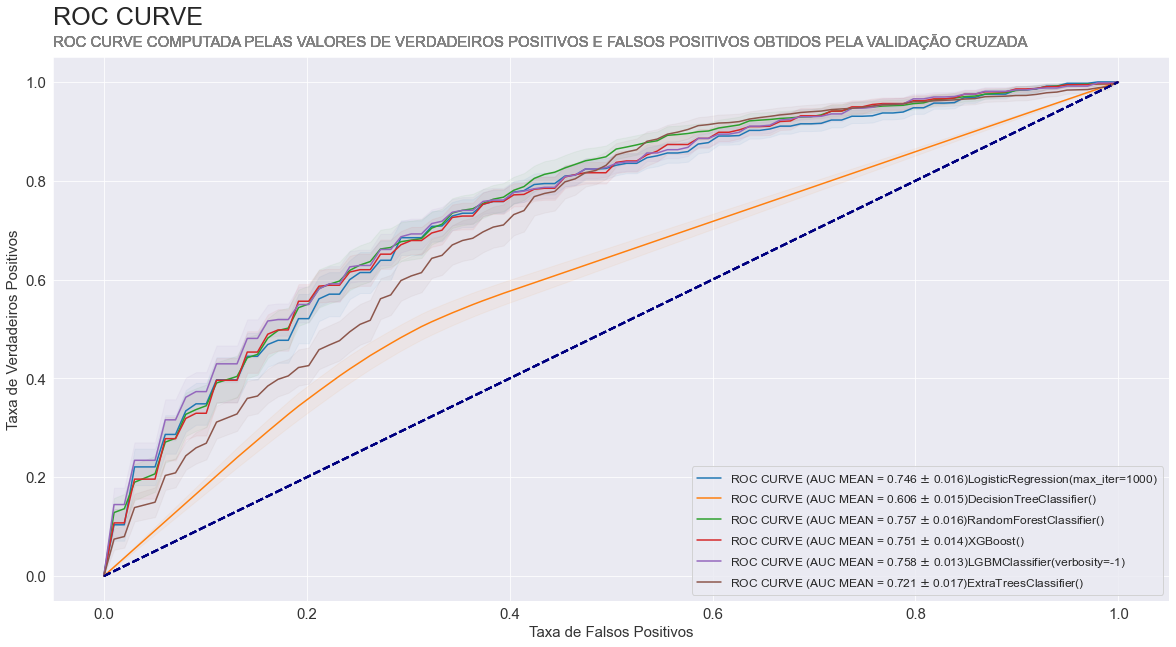

In [13]:
ax = lr.plot_roc_curve()
dt.plot_roc_curve(ax=ax)
rf.plot_roc_curve(ax=ax)
xg.plot_roc_curve(ax=ax, name_estimator='XGBoost()')
lgbm.plot_roc_curve(ax=ax)
et.plot_roc_curve(ax=ax)
plt.show()

# Reamostragem

In [14]:
df['ICU'].value_counts()

0    189
1    105
Name: ICU, dtype: int64

In [15]:
icu0 = df.query('ICU == 0')
icu1 = df.query('ICU == 1')

In [16]:
icu1_resample = resample(icu1,
                         n_samples=len(icu0),
                         random_state=SEED)

In [17]:
df_resample = pd.concat([icu1_resample, icu0], axis=0)
df_resample['ICU'].value_counts()

1    189
0    189
Name: ICU, dtype: int64

In [18]:
lr = Classifier(LogisticRegression, df_resample, max_iter=1000)
lr.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LogisticRegression(max_iter=1000)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.780 ± 0.013   |  
ACCURACY  MÉDIA    : 0.726 ± 0.014   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.729 ± 0.014   |0.720     |0.733    
RECALL MÉDIO       : 0.726 ± 0.014   |0.741     |0.712     
F1-SCORE  MÉDIO    : 0.725 ± 0.014   |0.730     |0.722    

TEMPO MÉDIO DE TREINAMENTO:0.04


In [19]:
dt = Classifier(DecisionTreeClassifier, df_resample)
dt.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : DecisionTreeClassifier()
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.797 ± 0.011   |  
ACCURACY  MÉDIA    : 0.797 ± 0.011   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.808 ± 0.011   |0.857     |0.754    
RECALL MÉDIO       : 0.797 ± 0.011   |0.712     |0.881     
F1-SCORE  MÉDIO    : 0.794 ± 0.012   |0.778     |0.812    

TEMPO MÉDIO DE TREINAMENTO:0.007


In [20]:
rf = Classifier(RandomForestClassifier, df_resample)
rf.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : RandomForestClassifier()
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.946 ± 0.007   |  
ACCURACY  MÉDIA    : 0.870 ± 0.011   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.873 ± 0.011   |0.889     |0.852    
RECALL MÉDIO       : 0.870 ± 0.011   |0.845     |0.895     
F1-SCORE  MÉDIO    : 0.870 ± 0.011   |0.867     |0.873    

TEMPO MÉDIO DE TREINAMENTO:0.176


In [21]:
et = Classifier(ExtraTreesClassifier, df_resample)
et.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : ExtraTreesClassifier()
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.941 ± 0.008   |  
ACCURACY  MÉDIA    : 0.867 ± 0.011   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.869 ± 0.011   |0.854     |0.880    
RECALL MÉDIO       : 0.867 ± 0.011   |0.885     |0.849     
F1-SCORE  MÉDIO    : 0.866 ± 0.011   |0.869     |0.864    

TEMPO MÉDIO DE TREINAMENTO:0.153


In [22]:
xg = Classifier(XGBClassifier, df_resample, verbosity=0)
xg.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|---------------

In [23]:
lgbm = Classifier(LGBMClassifier, df_resample, verbosity=-1)
lgbm.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LGBMClassifier(verbosity=-1)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.939 ± 0.008   |  
ACCURACY  MÉDIA    : 0.860 ± 0.010   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.864 ± 0.010   |0.889     |0.835    
RECALL MÉDIO       : 0.860 ± 0.010   |0.823     |0.897     
F1-SCORE  MÉDIO    : 0.860 ± 0.010   |0.855     |0.865    

TEMPO MÉDIO DE TREINAMENTO:0.038


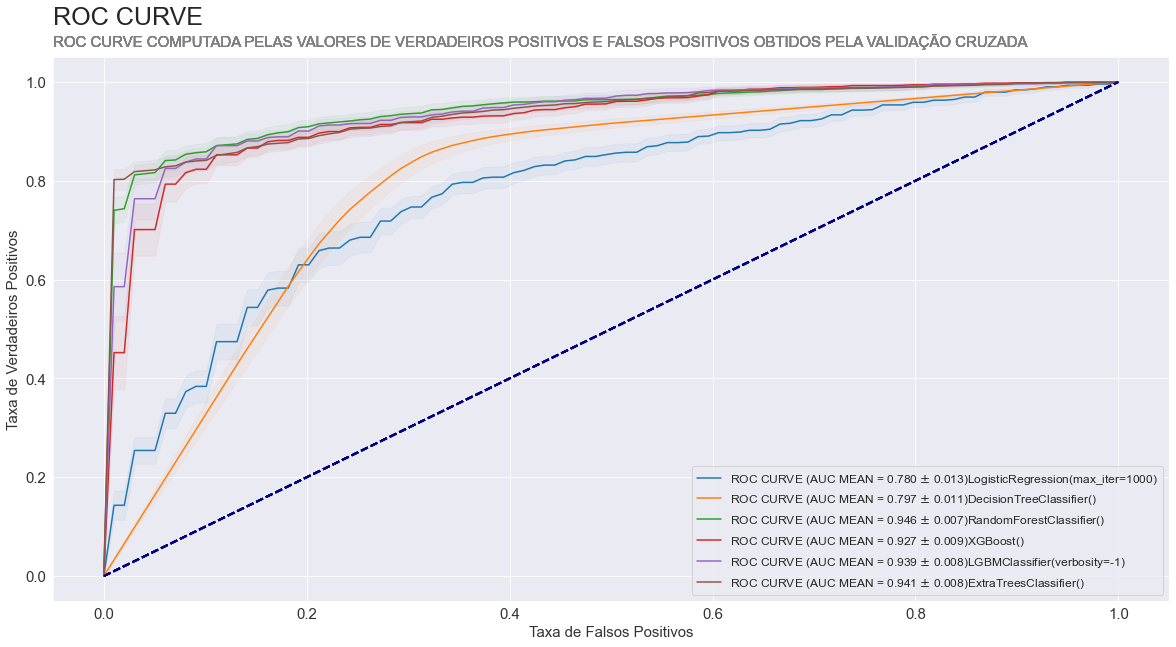

In [24]:
ax = lr.plot_roc_curve()
dt.plot_roc_curve(ax=ax)
rf.plot_roc_curve(ax=ax)
xg.plot_roc_curve(ax=ax, name_estimator='XGBoost()')
lgbm.plot_roc_curve(ax=ax)
et.plot_roc_curve(ax=ax)
plt.show()

### Otimização dos hiperparâmetros

In [25]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=SEED)
X = df_resample.drop('ICU', axis=1)
y = df_resample['ICU']

In [36]:
pipe = Pipeline([
    ('feature_selection', PipelineHelper([
        ('rf',  SelectFromModel(RandomForestClassifier()))])),
    ('classifier', PipelineHelper([
        ('rf', RandomForestClassifier()),
        ('et', ExtraTreesClassifier())
    ])),
])

params = {
    'feature_selection__selected_model': pipe.named_steps['feature_selection'].generate({
        'rf__threshold': [0,  'median', 'mean', '1.25*mean'],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'rf__max_depth': [None, 5, 10, 15,20],
        'rf__random_state' : [SEED],
        'rf__n_estimators': [100, 200, 400, 800],
        'rf__min_samples_split': [2, 3, 5],
        'rf__min_samples_leaf': [1,2,3],
        'et__random_state' : [SEED],
        'et__max_depth': [None, 5, 10, 15, 20],
        'et__n_estimators': [100, 200, 400, 800],
        'et__min_samples_split': [2, 3, 5],
        'rf__min_samples_leaf': [1,2,3]
    })
}
grid = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=cv, scoring='f1', n_iter=100, random_state=SEED, refit='AUC')
start = time.time()
grid.fit(X,y)
end=time.time()
print(f'Os parâmetros do modelo com o melhor resultado foi {grid.best_params_}')
print(f'O melhor resultado para a média da ROC AUC foi de {grid.best_score_}')
print(f'O melhor modelo foi {grid.best_estimator_}')
print(f'O tempo para essa procura foi de {(end-start)/60} minutos')

Os parâmetros do modelo com o melhor resultado foi {'feature_selection__selected_model': ('rf', {'threshold': '1.25*mean'}), 'classifier__selected_model': ('et', {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 64541})}
O melhor resultado para a média da ROC AUC foi de 0.8862914691121208
O melhor modelo foi Pipeline(steps=[('feature_selection',
                 PipelineHelper(available_models={'rf': SelectFromModel(estimator=RandomForestClassifier(),
                                                                        threshold='1.25*mean')},
                                selected_model=SelectFromModel(estimator=RandomForestClassifier(),
                                                               threshold='1.25*mean'))),
                ('classifier',
                 PipelineHelper(available_models={'et': ExtraTreesClassifier(n_estimators=400,
                                                                             random_state=64541),
    

In [27]:
'''
pipe = Pipeline([
    ('feature_selection', PipelineHelper([
        ('rf',  SelectFromModel(RandomForestClassifier()))])),
    ('classifier', PipelineHelper([
        ('rf', RandomForestClassifier()),
        ('et', ExtraTreesClassifier()),
        ('lgbm', LGBMClassifier())
    ])),
])

params = {
    'feature_selection__selected_model': pipe.named_steps['feature_selection'].generate({
        'rf__threshold': [0,  'median', 'mean', '1.25*mean'],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'rf__max_depth': [None, 5, 10, 15,20],
        'rf__random_state' : [SEED],
        'rf__n_estimators': [100, 200, 400, 800],
        'rf__min_samples_split': [2, 3, 5],
        'rf__min_samples_leaf': [1,2,3],
        'et__random_state' : [SEED],
        'et__max_depth': [None, 5, 10, 15, 20],
        'et__n_estimators': [100, 200, 400, 800],
        'et__min_samples_split': [2, 3, 5],
        'rf__min_samples_leaf': [1,2,3],
        'lgbm__random_state' : [SEED],
        'lgbm__n_estimators': [100, 200, 400, 800],
        'lgbm__boosting_type':['dart', 'gbdt'],
        'lgbm__max_depth': [None, 5, 10, 15, 20],
        'lgbm__num_leaves': [10, 25, 50]
    })
}
grid = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=cv, scoring='f1', n_iter=10, random_state=SEED, refit='AUC')
start = time.time()
grid.fit(X,y)
end=time.time()
print(f'Os parâmetros do modelo com o melhor resultado foi {grid.best_params_}')
print(f'O melhor resultado para a média da ROC AUC foi de {grid.best_score_}')
print(f'O melhor modelo foi {grid.best_estimator_}')
print(f'O tempo para essa procura foi de {(end-start)/60} minutos')'''

"\npipe = Pipeline([\n    ('feature_selection', PipelineHelper([\n        ('rf',  SelectFromModel(RandomForestClassifier()))])),\n    ('classifier', PipelineHelper([\n        ('rf', RandomForestClassifier()),\n        ('et', ExtraTreesClassifier()),\n        ('lgbm', LGBMClassifier())\n    ])),\n])\n\nparams = {\n    'feature_selection__selected_model': pipe.named_steps['feature_selection'].generate({\n        'rf__threshold': [0,  'median', 'mean', '1.25*mean'],\n    }),\n    'classifier__selected_model': pipe.named_steps['classifier'].generate({\n        'rf__max_depth': [None, 5, 10, 15,20],\n        'rf__random_state' : [SEED],\n        'rf__n_estimators': [100, 200, 400, 800],\n        'rf__min_samples_split': [2, 3, 5],\n        'rf__min_samples_leaf': [1,2,3],\n        'et__random_state' : [SEED],\n        'et__max_depth': [None, 5, 10, 15, 20],\n        'et__n_estimators': [100, 200, 400, 800],\n        'et__min_samples_split': [2, 3, 5],\n        'rf__min_samples_leaf': [1,2,3

In [37]:
best2 = Pipeline(steps=[('feature_selection',
                 PipelineHelper(available_models={'rf': SelectFromModel(estimator=RandomForestClassifier(),
                                                                        threshold='1.25*mean')},
                                selected_model=SelectFromModel(estimator=RandomForestClassifier(),
                                                               threshold='1.25*mean'))),
                ('classifier',
                 PipelineHelper(available_models={'et': ExtraTreesClassifier(n_estimators=400,
                                                                             random_state=64541),
                                                  'rf': RandomForestClassifier()},
                                selected_model=ExtraTreesClassifier(n_estimators=400,
                                                                    random_state=64541)))])

In [38]:
be2 = Classifier(best2, df_resample)
be2.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : Pipeline(steps=[('feature_selection',
                 PipelineHelper(available_models={'rf': SelectFromModel(estimator=RandomForestClassifier(),
                                                                        threshold='1.25*mean')},
                                selected_model=SelectFromModel(estimator=RandomForestClassifier(),
                                                               threshold='1.25*mean'))),
                ('classifier',
                 PipelineHelper(available_models={'et': ExtraTreesClassifier(n_estimators=400,
                                                                             random_state=64541),
                                                  'rf': RandomForestClassifier()},
                                selected_model=ExtraTreesClassifier(n_estima

In [28]:
best = Pipeline(steps=[('feature_selection',
                 PipelineHelper(available_models={'rf': SelectFromModel(estimator=RandomForestClassifier(),
                                                                        threshold='1.25*mean')},
                                selected_model=SelectFromModel(estimator=RandomForestClassifier(),
                                                               threshold='1.25*mean'))),
                ('classifier',
                 PipelineHelper(available_models={'et': ExtraTreesClassifier(n_estimators=400,
                                                                             random_state=64541),
                                                  'lgbm': LGBMClassifier(),
                                                  'rf': RandomForestClassifier()},
                                selected_model=ExtraTreesClassifier(n_estimators=400,
                                                                    random_state=64541)))])

In [29]:
be = Classifier(best, df_resample)
be.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : Pipeline(steps=[('feature_selection',
                 PipelineHelper(available_models={'rf': SelectFromModel(estimator=RandomForestClassifier(),
                                                                        threshold='1.25*mean')},
                                selected_model=SelectFromModel(estimator=RandomForestClassifier(),
                                                               threshold='1.25*mean'))),
                ('classifier',
                 PipelineHelper(available_models={'et': ExtraTreesClassifier(n_estimators=400,
                                                                             random_state=64541),
                                                  'lgbm': LGBMClassifier(),
                                                  'rf': RandomForestClassifier()},


<AxesSubplot:title={'left':'Matriz de confusão do modelo BEST\n'}, xlabel='VALORES PREVISTOS', ylabel='VALORES REAIS'>

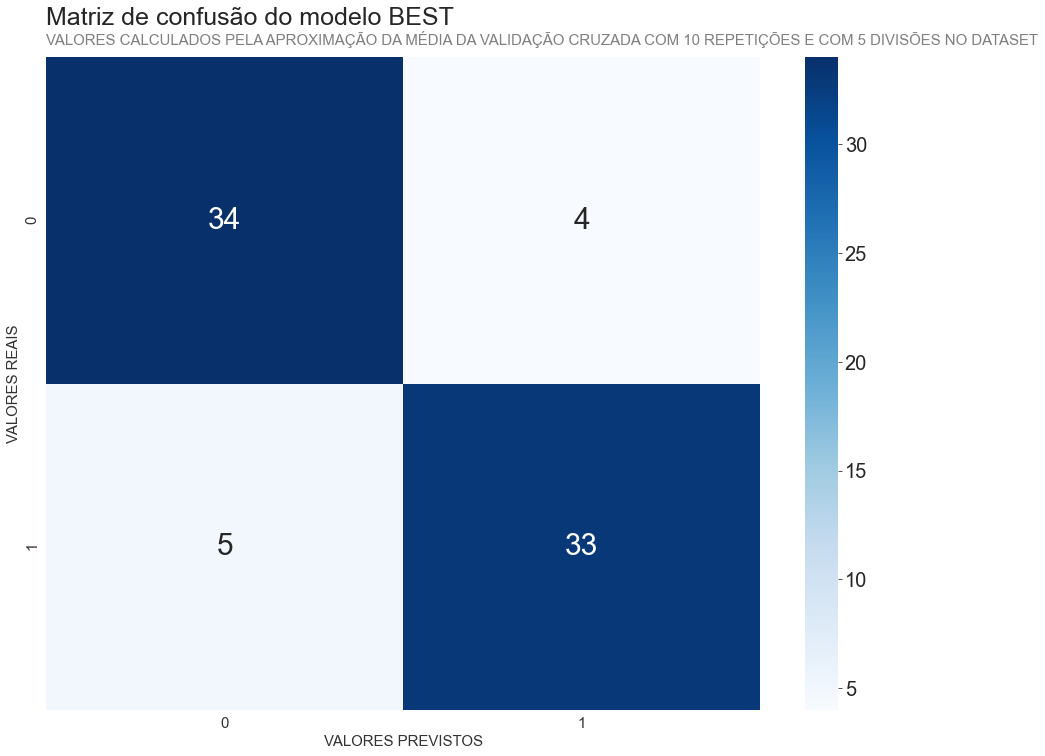

In [30]:
be.plot_confusion(name_estimator='BEST')

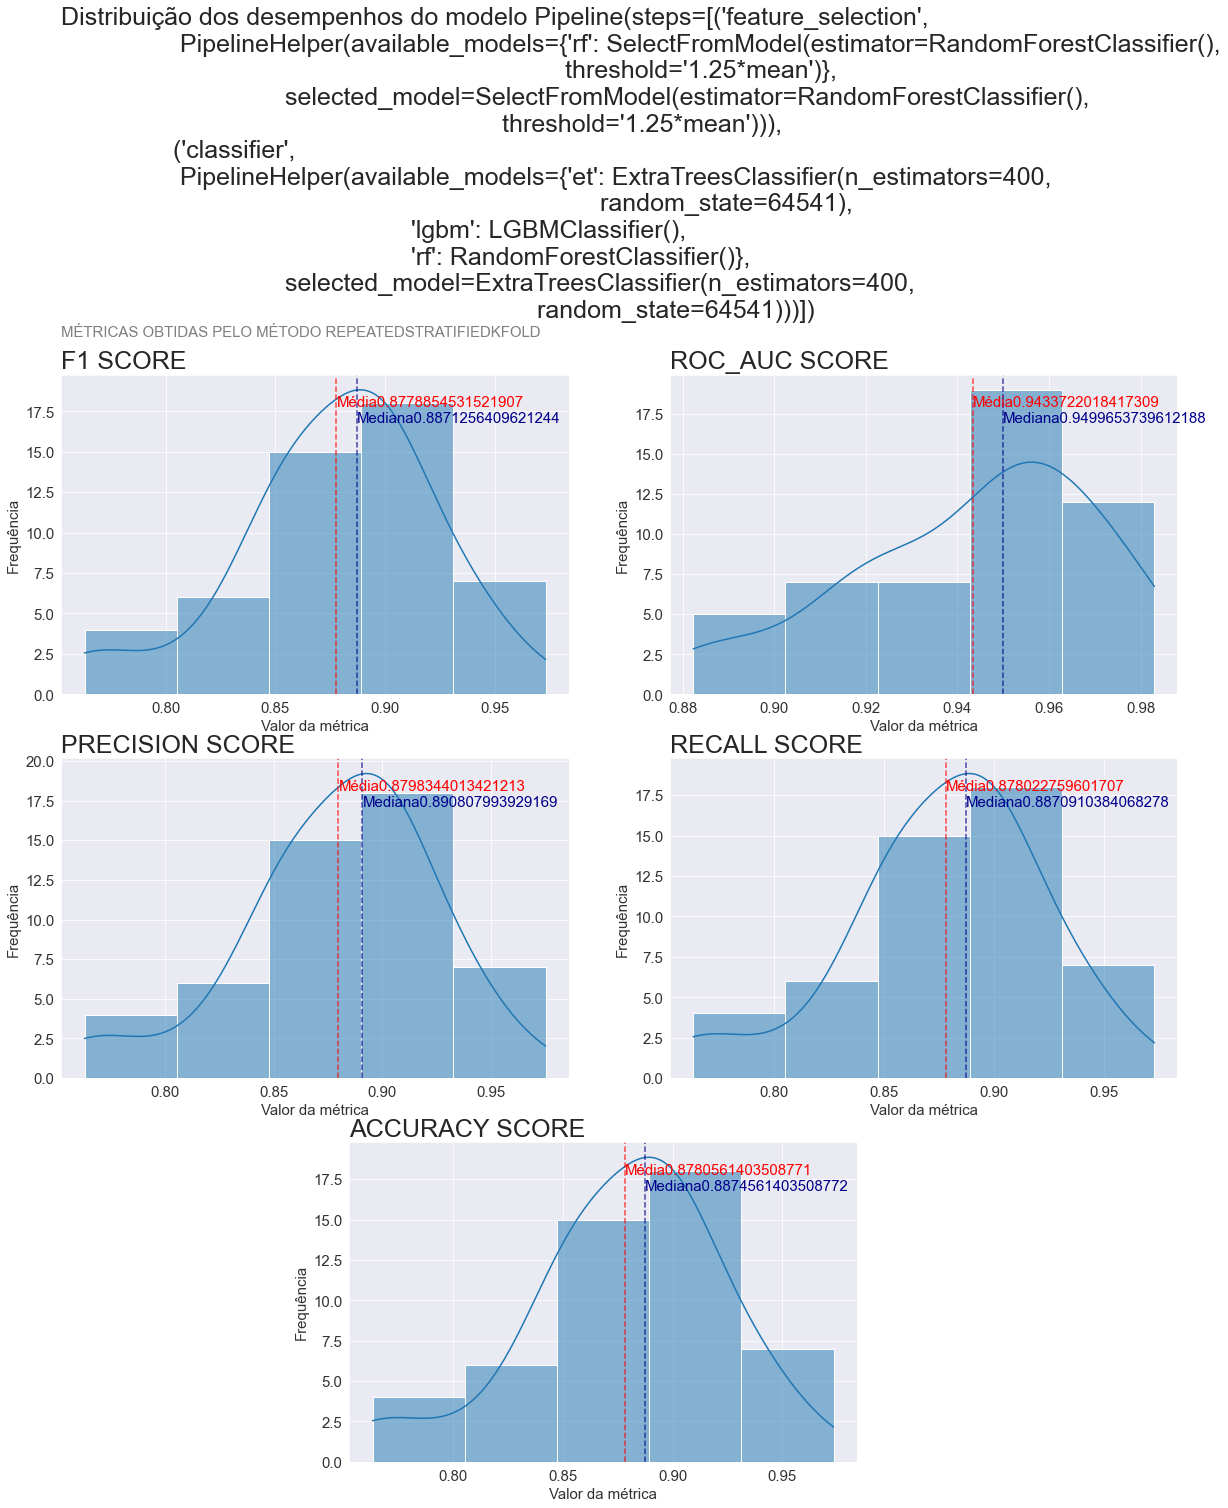

In [31]:
be.hist_metrics(kde=True)
plt.show()

# Validação dos resultados

A fim de se obter a maior certeza nesses resultados e, testar se essa validação cruzada com 10 divisões e 5 repetições é a ideal vou testar a hipótese nula que as métricas obtidas seguem uma distribuição normal, e com isso, podemos definir, de forma confirmatória, o intervalo de confiança para média de cada métrica igual a:

## $$\mu = \bar{x} \pm \frac{\sigma}{\sqrt{n}}$$

#### Onde $\mu$ é a média populacional, $\bar{x}$ é a média da amostra das métricas calculadas, $\sigma$ é o desvio padrão amostral calculado e n é o tamanho da amostra, que no nosso caso é 50, 5 repetiçoes e 10 divisões do dataset $5\:X\:10 = 50$

Primeiramente vou observar essas métricas por meio de um histograma a fim de entender suas distribuições.

In [32]:
for metric,value in be.scores.items():
    _, p_value = normaltest(value)
    print(metric,p_value)

f1 0.0919986346836629
roc_auc 0.16918846710462246
precision 0.06150108732475053
recall 0.08723881925280677
accuracy 0.09004659017061646
